In [1]:
import numpy as np
import pandas as pd
import linearsolve as ls
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

# Homework 8

**Instructions:** Complete the notebook below. Download the completed notebook in HTML format. Upload assignment using Canvas.

**Due:** Mar. 4 at **2pm.**

## Exercise: Changing $\beta$ in Prescott's Real Business Cycle Model

Recall that the equilibrium conditions for Prescott's RBC model are:

\begin{align}
\frac{1}{C_t} & = \beta E_t \left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1}L_{t+1}^{1-\alpha} +1-\delta }{C_{t+1}}\right]\\
\frac{\varphi}{1-L_t} & = \frac{(1-\alpha)A_tK_t^{\alpha}L_t^{-\alpha}}{C_t} \\
Y_t & = A_t K_t^{\alpha}L_t^{1-\alpha}\\
K_{t+1} & = I_t + (1-\delta) K_t\\
Y_t & = C_t + I_t\\
\log A_{t+1} & = \rho \log A_t + \epsilon_{t+1}
\end{align}

where $\epsilon_{t+1} \sim \mathcal{N}(0,\sigma^2)$. 

The objective is use `linearsolve` to simulate impulse responses to a TFP shock for $\beta = 0.96,0.97,0.98,0.99$. Other parameter values are given in the table below:

| $$\sigma$$ | $$\rho$$  | $$\varphi$$ | $$\alpha$$ | $$\delta $$ |
|------------|-----------|-------------|------------|-------------|
| 0.006      | 0.75      | 1.7317      | 0.35       |  0.025      |


## Model Preparation

As usual, we recast the model in the form required for `linearsolve`. Write the model with all variables moved to the left-hand side of the equations and dropping the expecations operator $E_t$ and the exogenous shock $\epsilon_{t+1}$:

\begin{align}
0 & = \beta\left[\frac{\alpha A_{t+1}K_{t+1}^{\alpha-1}L_{t+1}^{1-\alpha} +1-\delta }{C_{t+1}}\right] - \frac{1}{C_t}\\
0 & = \frac{(1-\alpha)A_tK_t^{\alpha}L_t^{-\alpha}}{C_t} - \frac{\varphi}{1-L_t}\\
0 & = A_t K_t^{\alpha}L_t^{1-\alpha} - Y_t\\
0 & = I_t + (1-\delta) K_t - K_{t+1}\\
0 & = C_t + I_t - Y_t\\
0 & = \rho \log A_t - \log A_{t+1}
\end{align}

Remember, capital and TFP are called *state variables* because they're $t+1$ values are predetermined. Output, consumption, and investment are called a *costate* or *control* variables. Note that the model as 5 equations in 5 endogenous variables.

## Initialization, Approximation, and Solution

The next several cells initialize the model in `linearsolve` and then approximate and solve it.

In [2]:
# Create a variable called 'parameters' that stores the model parameter values in a Pandas Series.

parameters = pd.Series({"sigma": .006, "rho": .75, "phi": 1.7317, "alpha": .35, "delta": .025})




# Print the model's parameters
print(parameters)

sigma    0.0060
rho      0.7500
phi      1.7317
alpha    0.3500
delta    0.0250
dtype: float64


In [3]:
# Create variable called 'varNames' that stores the variable names in a list with state variables ordered first.
var_names = ["a", "k", "y", "c", "i", "l"]

# Create variable called 'shockNames' that stores an exogenous shock name for each state variable.
shockNames = ["e_a", "e_k"]

In [10]:
# Define a function that evaluates the equilibrium conditions of the model solved for zero
def equilibrium(forward, current, parameters):

    # Parameters
    p = parameters

    # Current variables
    cur = current

    # Forward variables
    fwd = forward

    # Euler equation
    MPK = p.alpha * fwd.a * fwd.k**(p.alpha-1) * fwd.l**(1-p.alpha)
    euler = p.beta * (MPK + 1 - p.delta)/fwd.c - 1/cur.c 

    # Labor-labor choise
    MPL = (1 - p.alpha) * cur.a * cur.k**p.alpha * cur.l**(-p.alpha)
    labor_leisure = MPL/cur.c - p.phi/(1-cur.l)


    # Production function
    production = cur.a * cur.k**p.alpha * cur.l**(1-p.alpha) - cur.y

    # Capital evolution
    capital = cur.i + (1-p.delta) * cur.k - fwd.k

    # Market clearing
    clearing = cur.c + cur.i - cur.y 

    # Exogenous tfp
    TFP = p.rho * np.log(cur.a) - np.log(fwd.a)


    # Stack equilibrium conditions into a numpy array
    return np.array([euler, labor_leisure, production, capital, clearing, TFP])








Next, initialize the model using `ls.model` which takes the following required arguments:

* `equations`
* `n_states`
* `var_names`
* `shock_names`
* `parameters`

In [11]:
# Initialize the model into a variable named 'rbc_model'
rbc_model = ls.model(equilibrium, n_states = 2, var_names = var_names, shock_names = shockNames, parameters = parameters)





## SImulation and Plotting

Create a $2\times 2$ grid of plots containing the impulse responses of TFP, output, labor, and consumption to a one percent shock to TFP for each of the values for $\beta$: 0.96,0.97,0.98,0.99. Your figure should have a legend that clearly indicates which curves were produced from 


Here are the steps that that you should take:

1. Initilize figure and axes for plotting.
2. Iterate over each desired value for $\beta$.
    1. Set `rbc_model.parameters['beta']` equal to current value of $\beta$.
    2. Use `rbc_model.compute_ss()` to compute the steady state with `guess` equal to `[1,4,1,1,1,0.5]`.
    3. Use `rbc_model.approximate_and_solve()` to approximate and solve the model with the current value of $\beta$.
    4. Use `rbc_model.impulse()` to compute the **31** period impulse response to a 0.01 unit shock to TFP in period 5.
    5. Add the computed impulse responses to the axes.
    
Be sure to add a legend somewhere in your figure so that it's clear which impulse response lines were determined by which value of $\beta$.

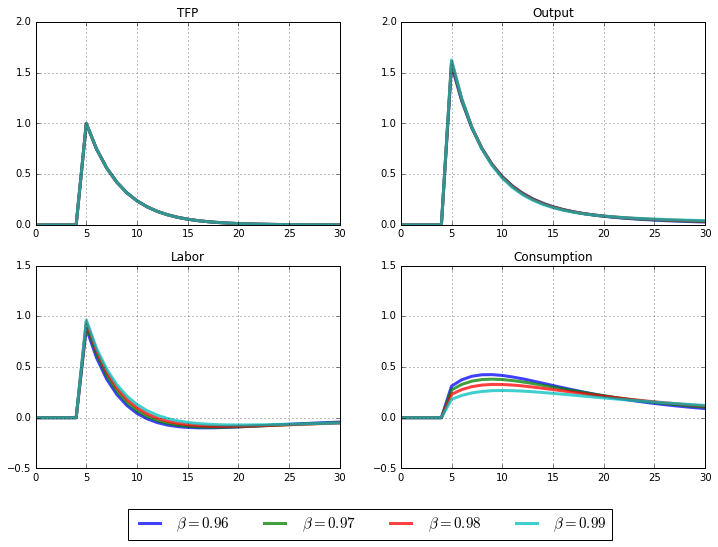

In [54]:
# Modified from class notebook

fig = plt.figure(figsize = (12,8))

ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)

ax0 = fig.add_subplot(1,1,1)
ax0.set_frame_on(False)
ax0.get_xaxis().set_visible(False)
ax0.get_yaxis().set_visible(False)

for beta in (.96, .97, .98, .99):
    rbc_model.parameters["beta"] = beta 
    rbc_model.compute_ss([1,4,1,1,1,0.5])
    rbc_model.approximate_and_solve()
    rbc_model.impulse(T = 31, t0 = 5, shocks = [0.01, 0])
    ax1.plot(rbc_model.irs["e_a"]["a"]*100,lw=3,alpha=0.75)
    ax2.plot(rbc_model.irs["e_a"]["y"]*100,lw=3,alpha=0.75)
    ax3.plot(rbc_model.irs["e_a"]["l"]*100,lw=3,alpha=0.75)
    ax4.plot(rbc_model.irs["e_a"]["c"]*100,lw=3,alpha=0.75)
    ax0.plot(0,0,lw=3,alpha=0.75,label= r"$\beta={0}$".format(beta))

ax1.set_title("TFP")
ax2.set_title("Output")
ax3.set_title("Labor")
ax4.set_title("Consumption")

ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.set_ylim([0,2])
ax2.set_ylim([0,2])
ax3.set_ylim([-0.5,1.5])
ax4.set_ylim([-0.5,1.5])

# Add legend below the figure. PROVIDED
legend = ax0.legend(loc= "upper center", bbox_to_anchor=(0.5,-0.075), ncol = 4, fontsize = 15)

In [ ]:
**Questions**

1. Describe in your own words how increasing $\beta$ from 0.96 to 0.99 affects the impulse response of consumption to a TFP shock.
2. Explain in your own words the intuition for *why* your observation in the previous question makes sense.
3. Describe in your own words how increasing $\beta$ from 0.96 to 0.99 affects the impulse response of labor to a TFP shock.
4. Explain in your own words the intuition for *why* your observation in the previous question makes sense.

**Answers**

1. Increasing beta decreases the impulse response curve for consumption. 

2. This make sense since a larger weight is being applied to future utility. As a result, consumption growth increases faster as beta increases. 

1. Increasing beta increases the impulse response curve for labor. 

2. This makes sense since the supply for labor shifts to the left. 

## Exercise: Monetary policy Regimes

In August 6, 1979, Paul Volcker began his first of two terms as chair of the Board of Governors of the Federal Reserve System. In the two decades prior to Volcker's appointment, inflation in the US had been acccelerating rapidly, as the graph produced by the code in the next cell shows:

<AxesSubplot:title={'center':'US GDP Deflator Inflation'}, xlabel='DATE', ylabel='Percent'>

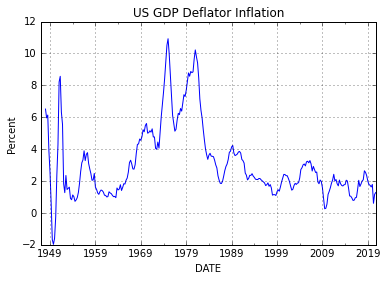

In [7]:
# Import GDP deflator data from FRED. CELL PROVIDED
deflator = pd.read_csv('https://fred.stlouisfed.org/data/GDPDEF.txt',sep='\s+',skiprows=15,index_col=0,parse_dates=True)

# Set deflator equal to 'VALUE' column of deflator
deflator = deflator['VALUE']

# Compute the inflation rate
inflation = (deflator - deflator.shift(4))/deflator.shift(4)*100

# Plot
inflation.plot(title='US GDP Deflator Inflation',ylabel='Percent',grid=True)

The decline and stabilization of inflation in the US starting in the early 1980s is widely attributed to Volcker's leadership. As chair, he pushed the FOMC to aggressively pursue tight monetary policy that led to a sharp contraction in the rate of money growth and an increase in the federal fund rate.

In light of this story, many economists argue that Volcker was the start of a new monetary policy *regime*. Before Volcker, the Fed pursued a looser monetary policy that allowed inflation to accelerate and starting with Volcker, the Fed has pursued a tighter monetary policy that is more aggressive to managing inflation.

Here you will test this proposition by estimating a monetary policy rule for the US on data before Volcker's arrival at the Fed and after. Basically, you will replicate the estimation at the end of class 16 for pre- and post-Volcker data.

### Preliminaries

The next block of code imports federal funds rate, GDP deflator inflation, and output gap data from FRED and returs the data as a DataFrame called `df`.

In [18]:
# Initial an empty DataFrame that will store data. CELL PROVIDED
df = pd.DataFrame()

# Import federal funds rate data from FRED. Use arguments: sep='\s+',skiprows=62,index_col=0,parse_dates=True
fed_funds = pd.read_csv('https://fred.stlouisfed.org/data/FEDFUNDS.txt',sep='\s+',skiprows=62,index_col=0,parse_dates=True)

# Set fed_funds equal to 'VALUE' column of fed_funds
fed_funds = fed_funds['VALUE']

# Use .resample('QS').mean() method of 'fed_funds' to convert the fed funds data from monthdy to quarterly
fed_funds = fed_funds.resample('QS').mean()

# Import GDP deflator data from FRED
deflator = pd.read_csv('https://fred.stlouisfed.org/data/GDPDEF.txt',sep='\s+',skiprows=15,index_col=0,parse_dates=True)

# Set deflator equal to 'VALUE' column of deflator
deflator = deflator['VALUE']

# Compute the inflation rate
inflation = (deflator - deflator.shift(4))/deflator.shift(4)*100

# Import real GDP data from FRED
gdp_actual = pd.read_csv('https://fred.stlouisfed.org/data/GDPC1.txt',sep='\s+',skiprows=17,index_col=0,parse_dates=True)

# Set gdp_actual equal to 'VALUE' column of gdp_actual
gdp_actual = gdp_actual['VALUE']

# Import potential real GDP data from FRED
gdp_potential = pd.read_csv('https://fred.stlouisfed.org/data/GDPPOT.txt',sep='\s+',skiprows=12,index_col=0,parse_dates=True)

# Set gdp_potential equal to 'VALUE' column of gdp_potential
gdp_potential = gdp_potential['VALUE']

# Create variable 'df' that is a DataFrame storing fed funds, inflation, actual and potential real GDP
df = pd.DataFrame({
    'fed_funds':fed_funds,
    'inflation':inflation,
    'gdp_actual':gdp_actual,
    'gdp_potential':gdp_potential
})

# Drop missing values from 'df'
df = df.dropna()

### The Output Gap

The output gap is measured as the percent difference of real GDP from the CBO's estimate of the potential real GDP:

\begin{align}
\text{Output gap} & = \left(\frac{\text{Real GDP}-\text{Real potential GDP}}{\text{Real potential GDP}}\right)\cdot 100
\end{align}

Real GDP has FRED series ID `GDPC1` and is available here: https://fred.stlouisfed.org/series/GDPC1. Notice that there are 17 lines of text *before* the line starting with "DATE".

In [25]:
# Construct an output gap column
df["output_gap"] = (df.gdp_actual - df.gdp_potential)/df.gdp_potential * 100

,fed_funds,inflation,gdp_actual,gdp_potential,output_gap
DATE,,,,,
1954-07-01,1.030000,0.725639,2682.601,2721.074302,-1.413901
1954-10-01,0.986667,0.813962,2735.091,2738.310469,-0.117571
1955-01-01,1.343333,0.962662,2813.212,2755.016766,2.112337
1955-04-01,1.500000,1.291564,2858.988,2772.864269,3.105948
1955-07-01,1.940000,1.866209,2897.598,2790.460690,3.839413
...,...,...,...,...,...
2019-10-01,1.643333,1.628577,19253.959,19065.580000,0.988058
2020-01-01,1.260000,1.786868,19010.848,19153.980000,-0.747270
2020-04-01,0.060000,0.602813,17302.511,19242.040000,-10.079643


### OLS Regressions

The rule to be estimated is the same considered in Class 16:

\begin{align}
\hat{i}_t & = \bar{\imath} + \phi_{\pi}\pi_t + \phi_{y} y_t + \epsilon_t
\end{align}

where $\pi_t$ is the percent change in the GDP deflator over the previous year and $y_t$ is the output gap measured as the percent difference of real GDP from the CBO's estimate of the potential real GDP. $\phi_{\pi}$ is the weight that the FOMC places on inflation in the rule and $\phi_{y}$ is the weight that the central bank places on the output gap. $\epsilon_t$ is the residual of the regression. 

In [26]:
# Import statsmodels.api as sm
import statsmodels.api as sm 

For a Pandas DataFrame or Series with a DateTime index, you can select a subinterval of the dates using data strings in `.ilo[]`. For example, 

    `df.loc[:'1960']`
    
will return all data through the end of 1960. And:

    df.loc['08-2000':]
    
will return all data from and after August 2000.

#### Pre-Volcker Era

Estimate the monetary policy rule for dates through September 1979.

In [63]:
df_sep = df[:"09-1979"] # holds values indexed until september 1979

# Create variable 'X' with columns inflation, output and a constant
X = sm.add_constant(df_sep[["inflation", "output_gap"]])

# Create variable 'Y' equal to the federal funds rate
Y = df_sep["fed_funds"]

In [64]:
# Initialize OLS model
model = sm.OLS(Y, X)

# Fit OLS model
res = model.fit()

# Print regression results
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.716   
Dependent Variable: fed_funds        AIC:                354.9140
Date:               2021-02-27 13:57 BIC:                362.7594
No. Observations:   101              Log-Likelihood:     -174.46 
Df Model:           2                F-statistic:        127.2   
Df Residuals:       98               Prob (F-statistic): 5.83e-28
R-squared:          0.722            Scale:              1.9096  
-------------------------------------------------------------------
             Coef.    Std.Err.      t      P>|t|    [0.025   0.975]
-------------------------------------------------------------------
const        1.2483     0.2644    4.7211   0.0000   0.7236   1.7730
inflation    0.8751     0.0555   15.7668   0.0000   0.7649   0.9852
output_gap   0.3102     0.0589    5.2618   0.0000   0.1932   0.4271
-----------------------------------------------------------------
Omnibus:              0.088        Durbin-Watson:           0.334
Prob(Omnibus):        0.957        Jarque-Bera (JB):        0.258
Skew:                 0.016        Prob(JB):                0.879
Kurtosis:             2.754        Condition No.:           9    
=================================================================

"""

#### Post-Volcker Era

Estimate the monetary policy rule for dates after October 1979.

In [66]:
df_oct = df["10-1979":] # holds values indexed after October 1979

# Create variable 'X' with columns inflation, output and a constant
X = sm.add_constant(df_oct[["inflation", "output_gap"]])

# Create variable 'Y' equal to the federal funds rate
Y = df_oct["fed_funds"]

In [67]:
# Initialize OLS model
model = sm.OLS(Y, X)

# Fit OLS model
res = model.fit()

# Print regression results
res.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Results: Ordinary least squares
=================================================================
Model:              OLS              Adj. R-squared:     0.715   
Dependent Variable: fed_funds        AIC:                728.4910
Date:               2021-02-27 13:59 BIC:                737.8089
No. Observations:   165              Log-Likelihood:     -361.25 
Df Model:           2                F-statistic:        206.7   
Df Residuals:       162              Prob (F-statistic): 2.58e-45
R-squared:          0.718            Scale:              4.7550  
------------------------------------------------------------------
                Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
------------------------------------------------------------------
const           0.0274    0.3148   0.0870  0.9308  -0.5942  0.6489
inflation       1.8517    0.0912  20.3130  0.0000   1.6717  2.0318
output_gap      0.2719    0.0828   3.2844  0.0013   0.1084  0.4353
-----------------------------------------------------------------
Omnibus:               16.806       Durbin-Watson:          0.158
Prob(Omnibus):         0.000        Jarque-Bera (JB):       5.790
Skew:                  0.110        Prob(JB):               0.055
Kurtosis:              2.109        Condition No.:          7    
=================================================================

"""

**Questions**

1. Compare the results from the two regressions. For which monetary policy era is the estimated coefficient on inflation greater?
2. How do your results help to explain the high and variable inflation of the 1960s and 1970s and the lower and more stable inflation of the 1980s and after?

**Answers**

1. The monetary policy before the 1980's has a greater estimated coefficient. 

2. The percent deviation of real GDP from the trend (output gap) decreased for the results after 1980. 